<a href="https://colab.research.google.com/github/TimurMMD/Big-data-UEL-project/blob/main/XGBoost_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
!pip install -q findspark
!pip install pyspark py4j
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()
spark_bin_path = os.path.join(os.environ["SPARK_HOME"], "bin")

# Check if the spark-submit file exists
spark_submit_path = os.path.join(spark_bin_path, "spark-submit")
if not os.path.exists(spark_submit_path):
    print("Error: spark-submit not found at", spark_submit_path)
    print("Please verify your Spark installation.")
    exit(1)
# Add spark_bin_path to the PATH environment variable
os.environ["PATH"] += os.pathsep + spark_bin_path

# Now try to import and use SparkSession
try:
    from pyspark.sql import SparkSession

    spark = SparkSession.builder.master("local[*]").getOrCreate()
    print("SparkSession created successfully.")
except Exception as e:
    print("Error creating SparkSession:", e)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b9b2dd183b12b9b65c8a073339058c8d2dc2dd46e77e52d17569dbf94f9b14f5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
SparkSession created successfully.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from  pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [ ]:
data = spark.read.csv('/content/dataset.csv', inferSchema=True, header=True)

In [ ]:
data.show()

+--------------------+---+-----------------+--------------+---------------------+----------+--------+-------------+--------------+-------------------------+-----------------+
|          occupation|age|  education_level|marital_status|communication_channel|call_month|call_day|call_duration|call_frequency|previous_campaign_outcome|conversion_status|
+--------------------+---+-----------------+--------------+---------------------+----------+--------+-------------+--------------+-------------------------+-----------------+
|administrative_staff| 28|      high_school|       married|         unidentified| September|       9|            1|             1|               successful|    not_converted|
|administrative_staff| 58|     unidentified|       married|         unidentified|      June|       5|          307|             2|             unidentified|    not_converted|
|             jobless| 40|      high_school|      divorced|               mobile|  February|       4|          113|          

In [ ]:
#Change the values in the target column
from pyspark.sql.functions import when,col
data2 = data.withColumn("conversion_status", when(data.conversion_status == "not_converted", 0)
                                 .when(data.conversion_status == "converted", 1))

In [ ]:
data2.show()

+--------------------+---+-----------------+--------------+---------------------+----------+--------+-------------+--------------+-------------------------+-----------------+
|          occupation|age|  education_level|marital_status|communication_channel|call_month|call_day|call_duration|call_frequency|previous_campaign_outcome|conversion_status|
+--------------------+---+-----------------+--------------+---------------------+----------+--------+-------------+--------------+-------------------------+-----------------+
|administrative_staff| 28|      high_school|       married|         unidentified| September|       9|            1|             1|               successful|                0|
|administrative_staff| 58|     unidentified|       married|         unidentified|      June|       5|          307|             2|             unidentified|                0|
|             jobless| 40|      high_school|      divorced|               mobile|  February|       4|          113|          

In [ ]:
#Define columns in the dataset
numerical_cols = ['age', 'call_day', 'call_duration', 'call_frequency']
categorical_cols = ['occupation', 'education_level', 'marital_status', 'communication_channel', 'call_month', 'previous_campaign_outcome']
target_col = 'conversion_status'


In [ ]:
# Prepare data for machine learning model
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed").fit(data2) for col in categorical_cols]
pipeline = Pipeline(stages=indexers)
data_indexed = pipeline.fit(data).transform(data2)
assembler = VectorAssembler(inputCols=numerical_cols + [col+"_indexed" for col in categorical_cols], outputCol="features")
data_transformed = assembler.transform(data_indexed)

# Initialize XGBoost classifier
xgb_classifier = SparkXGBClassifier(
    features_col="features",
    label_col=target_col,
    prediction_col="prediction",
    eval_metric="auc"
)

# Split the data into training and testing sets
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# Train XGBmodel
model = xgb_classifier.fit(train_data)

# Make a prediction
predictions = model.transform(test_data)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'eval_metric': 'auc', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol=target_col)
auroc = evaluator.evaluate(predictions)

# Display AUROC
print("AUROC:", auroc)



AUROC: 0.9292162849831324


In [ ]:
# Calculate and display the confusion matrix
prediction_and_labels = predictions.select("prediction", target_col).rdd.map(lambda row: (float(row["prediction"]), float(row[target_col])))
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)






/content/spark-3.5.0-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[7653.  314.]
 [ 560.  521.]]


In [ ]:
# Calculate accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision:", precision)

# Calculate Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print("Recall:", recall)


# Calculate F1 score
f1_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print("F1 Score:", f1_score)

Accuracy: 0.9034040671971706
Precision: 0.8950337780261439
Recall: 0.9034040671971707
F1 Score: 0.8979372914341456


In [ ]:
#Define a grid of hyperparameters to tune
param_grid = ParamGridBuilder() \
    .addGrid(xgb_classifier.max_depth, [3, 6, 9]) \
    .addGrid(xgb_classifier.min_child_weight, [1, 5, 10]) \
    .addGrid(xgb_classifier.gamma, [0.1, 0.2, 0.3]) \
    .build()


In [ ]:
#Configure a cross-validator
evaluator = BinaryClassificationEvaluator(labelCol=target_col)
cross_validator = CrossValidator(
    estimator=xgb_classifier,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

In [ ]:
#Perform Cross-Validation and Hyperparameter Tuning
cv_model = cross_validator.fit(train_data)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'gamma': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'gamma': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'nthread': 1}
	train_ca

In [ ]:
#Make an evaluation after cross-validation
predictions_cv = cv_model.transform(test_data)

accuracy = accuracy_evaluator.evaluate(predictions_cv)
precision = precision_evaluator.evaluate(predictions_cv)
recall = recall_evaluator.evaluate(predictions_cv)
f1_score = f1_evaluator.evaluate(predictions_cv)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.9041777188328912
Precision: 0.8949127274218018
Recall: 0.9041777188328912
F1 Score: 0.8977978136455371


In [ ]:
best_model = cv_model.bestModel

In [ ]:
best_model_predictions = best_model.transform(test_data)

accuracy = accuracy_evaluator.evaluate(best_model_predictions)
precision = precision_evaluator.evaluate(best_model_predictions)
recall = recall_evaluator.evaluate(best_model_predictions)
f1_score = f1_evaluator.evaluate(best_model_predictions)

print("Best Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Best Model Evaluation Metrics:
Accuracy: 0.9051724137931034
Precision: 0.896819618808873
Recall: 0.9051724137931034
F1 Score: 0.8996044672345656


In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
#Printing ROC-curve
prediction_and_labels = best_model_predictions.select("prediction", target_col).rdd.map(lambda row: (float(row["prediction"]), float(row[target_col])))


In [ ]:
prediction_and_label_df = prediction_and_labels.toDF(["prediction", "label"])
prediction_and_label_df.show()

In [ ]:
prediction_and_label_df.printSchema()

root
 |-- prediction: double (nullable = true)
 |-- label: double (nullable = true)



In [ ]:
# Convert the DataFrame to Pandas for ROC curve calculation
prediction_and_label_pd = prediction_and_label_df.toPandas()

In [ ]:
fpr, tpr, _ = roc_curve(prediction_and_label_pd["label"], prediction_and_label_pd["prediction"])
roc_auc = auc(fpr, tpr)


In [ ]:
import pandas as pd

In [ ]:
roc = pd.DataFrame({'fpr': fpr, 'r_tpr': tpr})

In [ ]:
roc.head()

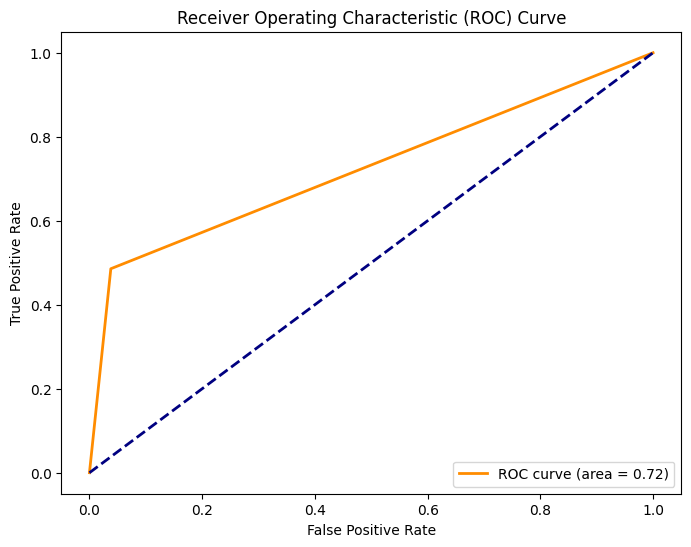

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()